<a href="https://colab.research.google.com/github/sysu17363098/CS231n/blob/master/Baseline_ipynb%EF%BC%88%E5%89%AF%E6%9C%AC%EF%BC%89.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **[Pytorch] Wikipedia Image Caption With Attention**

## **Install Required Libraries & load google drive**

In [ ]:
!pip install git+https://github.com/rwightman/pytorch-image-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/rwightman/pytorch-image-models to /tmp/pip-req-build-baoqlefm
  Running command git clone -q https://github.com/rwightman/pytorch-image-models /tmp/pip-req-build-baoqlefm
     |████████████████████████████████| 182 kB 4.4 MB/s 
  Created wheel for timm: filename=timm-0.7.0.dev0-py3-none-any.whl size=560593 sha256=d457baa7ceeee1cbc56ba177b98291d3086b76ec92d8228a135c6871ba077769
  Stored in directory: /tmp/pip-ephem-wheel-cache-ftv3ux58/wheels/69/3d/b0/be55cbadabd87a0e1875d63c7492d199097a39cc2433637650
Successfully built timm


In [ ]:
!pip install --upgrade wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 4.7 MB/s 
     |████████████████████████████████| 182 kB 65.9 MB/s 
     |████████████████████████████████| 168 kB 71.4 MB/s 
     |████████████████████████████████| 62 kB 1.8 MB/s 
     |████████████████████████████████| 168 kB 69.0 MB/s 
     |████████████████████████████████| 166 kB 74.1 MB/s 
     |████████████████████████████████| 166 kB 76.5 MB/s 
     |████████████████████████████████| 162 kB 67.3 MB/s 
     |████████████████████████████████| 162 kB 55.6 MB/s 
     |████████████████████████████████| 158 kB 72.2 MB/s 
     |████████████████████████████████| 157 kB 78.2 MB/s 
     |████████████████████████████████| 157 kB 75.3 MB/s 
     |████████████████████████████████| 157 kB 71.5 MB/s 
     |████████████████████████████████| 157 kB 78.8 MB/s 
     |████████████████████████████████| 157 kB 77.1 MB/s 
     |████████████████████████████

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 4.9 MB/s 
     |████████████████████████████████| 7.6 MB 50.8 MB/s 


In [ ]:
!pip install colorama

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Import Required Libraries**

In [ ]:
import os
import gc
import cv2
import copy
import time
import random
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import base64
import pickle

# For downloading images
from io import BytesIO

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp

# Utils
import joblib
from tqdm import tqdm
from collections import defaultdict

# Sklearn Imports
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold, KFold

# For Image Models
import timm

# For Transformer Models
from transformers import AutoTokenizer, AutoModel

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# For colored terminal text
from colorama import Fore, Back, Style
b_ = Fore.BLUE
sr_ = Style.RESET_ALL

# import Weights&Baises
import wandb

import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

## **Prepare Weights & Biases Account [*Optional*]**

In [ ]:
import wandb

wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## **Training Configuration**

In [ ]:
CONFIG = {"seed": 2022,
      "epochs": 50,
      "img_size": 256,
      "image_model_name": "tf_efficientnet_b0", # "tf_efficientnet_b0"
      "text_model_name": "xlm-roberta-base",
      "embedding_size": 768,
      "train_batch_size": 32,
      "valid_batch_size": 64,
      "learning_rate": 1e-3,
      "scheduler": 'CosineAnnealingLR',
      "min_lr": 1e-5,
      "T_max": 500,
      "weight_decay": 1e-6,
      "max_length": 32,
      "n_accumulate": 1,
      "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
      "root": "/content/drive/MyDrive/BDT SEM 1/ImageCaptionMatching/training/"
      }

CONFIG["tokenizer"] = AutoTokenizer.from_pretrained(CONFIG['text_model_name'])

Downloading:   0%|          | 0.00/615 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

## **Set Seed for Reproducibility**

In [ ]:
def set_seed(seed=88):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(CONFIG['seed'])

## **Dataset**

### default dataset

#### *Load & Split the Dataset*

In [ ]:
import pickle
filepath = "/content/drive/MyDrive/BDT SEM 1/ImageCaptionMatching/dataset/dataset.pkl"
with open(filepath, "rb") as fp:
  data = pickle.load(fp)

In [ ]:
print("size of the whole data:",len(data))

size of the whole data: 97052


split and shuffle the data

In [ ]:
import random
random.shuffle(data)

train_data = data[:45000]
valid_data = data[45000:60000]
print(f"Number of training samples: {len(train_data)}")
print(f"Number of validation samples: {len(valid_data)}")

Number of training samples: 45000
Number of validation samples: 15000


In [ ]:
train_data[10]

{'caption_title_and_reference_description': ['上图展示五个互相关联的质量的特性以及将这些特性联系起来的正比例常数。每一个质量的例子，都被认为包含全部的五个特性，然而，由于巨大的比例系数，通常很难确认两个或者三个以上的属性。史瓦西半径（rs）表示物质弯曲时空的能力。标准引力参数（μ）表示一个物体对其他物体施加牛顿引力的能力。惯性质量（m）表示质量对力的牛顿响应。静止质量（E0）表示质量转换成其他形式能量的能力。康普顿波长（λ）表示质量对局部时空几何的量子响应。',
  'Diagram kang ana ing dhuwur iki nggambaraké gayutané limang sipaté massa karo tetapan proporsionalitasé kang diubungaké karo limang konsèp. Nggal sampel massa dipercaya duwé limang sipat, Nanging amarga iku aji tetapan proporsionalitas kang gedhé, lumrahé angèl banget anggoné verifikasikaké punjul loro utawa telung sipat kang ana ing sampel massa tartemtu. * Jari-jari Schwarzschild (',
  'Diagram di atas mengilustrasikan hubungan antara lima sifat-sifat massa beserta tetapan proporsionalitas yang menghubungkan kelima konsep ini. Tiap-tiap sampel massa dipercayai memiliki lima sifat ini, namun oleh karena nilai tetapan proporsionalitas yang besar, umumnya sangat sulit untuk memverifikasi lebih dari dua atau tiga sifat pada sampel m

#### **Dataset Structure**

data: list of dictionaries
*   b64_bytes: base64 encoded bytes of the image file at a 300px resolution

*   caption_title_and_reference_description: list of captions
*   filename: filename of the image





#### *Prepare the DataLoader*

##### self-made dataset

In [ ]:
class WikipediaDataset(Dataset):
    def __init__(self, data, tokenizer, max_length, transforms=None):
        self.data = data
        self.max_len = max_length
        self.tokenizer = tokenizer
        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        # image
        image_bytes = base64.b64decode(self.data[index]['b64_bytes'])
        img = np.asarray(Image.open(BytesIO(image_bytes)).convert('RGB'))

        # caption
        caption = random.choice(self.data[index]['caption_title_and_reference_description'])
        caption = caption.replace('[SEP]', '</s>') # sep token for xlm-roberta
        inputs = self.tokenizer.encode_plus(
                caption,
                truncation=True,
                add_special_tokens=True,
                max_length=self.max_len,
                padding='max_length'
            )

        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        # filename
        filename = self.data[index]['filename']
        filename = filename.replace('[SEP]', '</s>') # sep token for xlm-roberta
        encode_name = self.tokenizer.encode_plus(
                filename,
                truncation=True,
                add_special_tokens=True,
                max_length=self.max_len,
                padding='max_length'
            )
        name_ids = encode_name['input_ids']
        name_mask = encode_name['attention_mask']


        if self.transforms:
            img = self.transforms(image=img)['image']

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'image': img,
            'name_ids': torch.tensor(name_ids, dtype=torch.long),
            'name_mask': torch.tensor(name_mask, dtype=torch.long)
        }

Augmentations

In [ ]:
data_transforms = {
    "train": A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        A.HorizontalFlip(p=0.5),
        A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
                max_pixel_value=255.0,
                p=1.0
            ),
        ToTensorV2()], p=1.),

    "valid": A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
                max_pixel_value=255.0,
                p=1.0
            ),
        ToTensorV2()], p=1.)
}

Build the DataLoader for training set and validation set

In [ ]:
train_dataset = WikipediaDataset(train_data, CONFIG["tokenizer"], CONFIG["max_length"],
                                 transforms=data_transforms["train"])
train_loader = DataLoader(train_dataset, batch_size=CONFIG['train_batch_size'],
                          num_workers=4, shuffle=True, pin_memory=True, drop_last=True)

valid_dataset = WikipediaDataset(valid_data, CONFIG["tokenizer"], CONFIG["max_length"],
                                 transforms=data_transforms["valid"])
valid_loader = DataLoader(valid_dataset, batch_size=CONFIG['valid_batch_size'],
                          num_workers=4, shuffle=False, pin_memory=True)

## **Model Architecture**

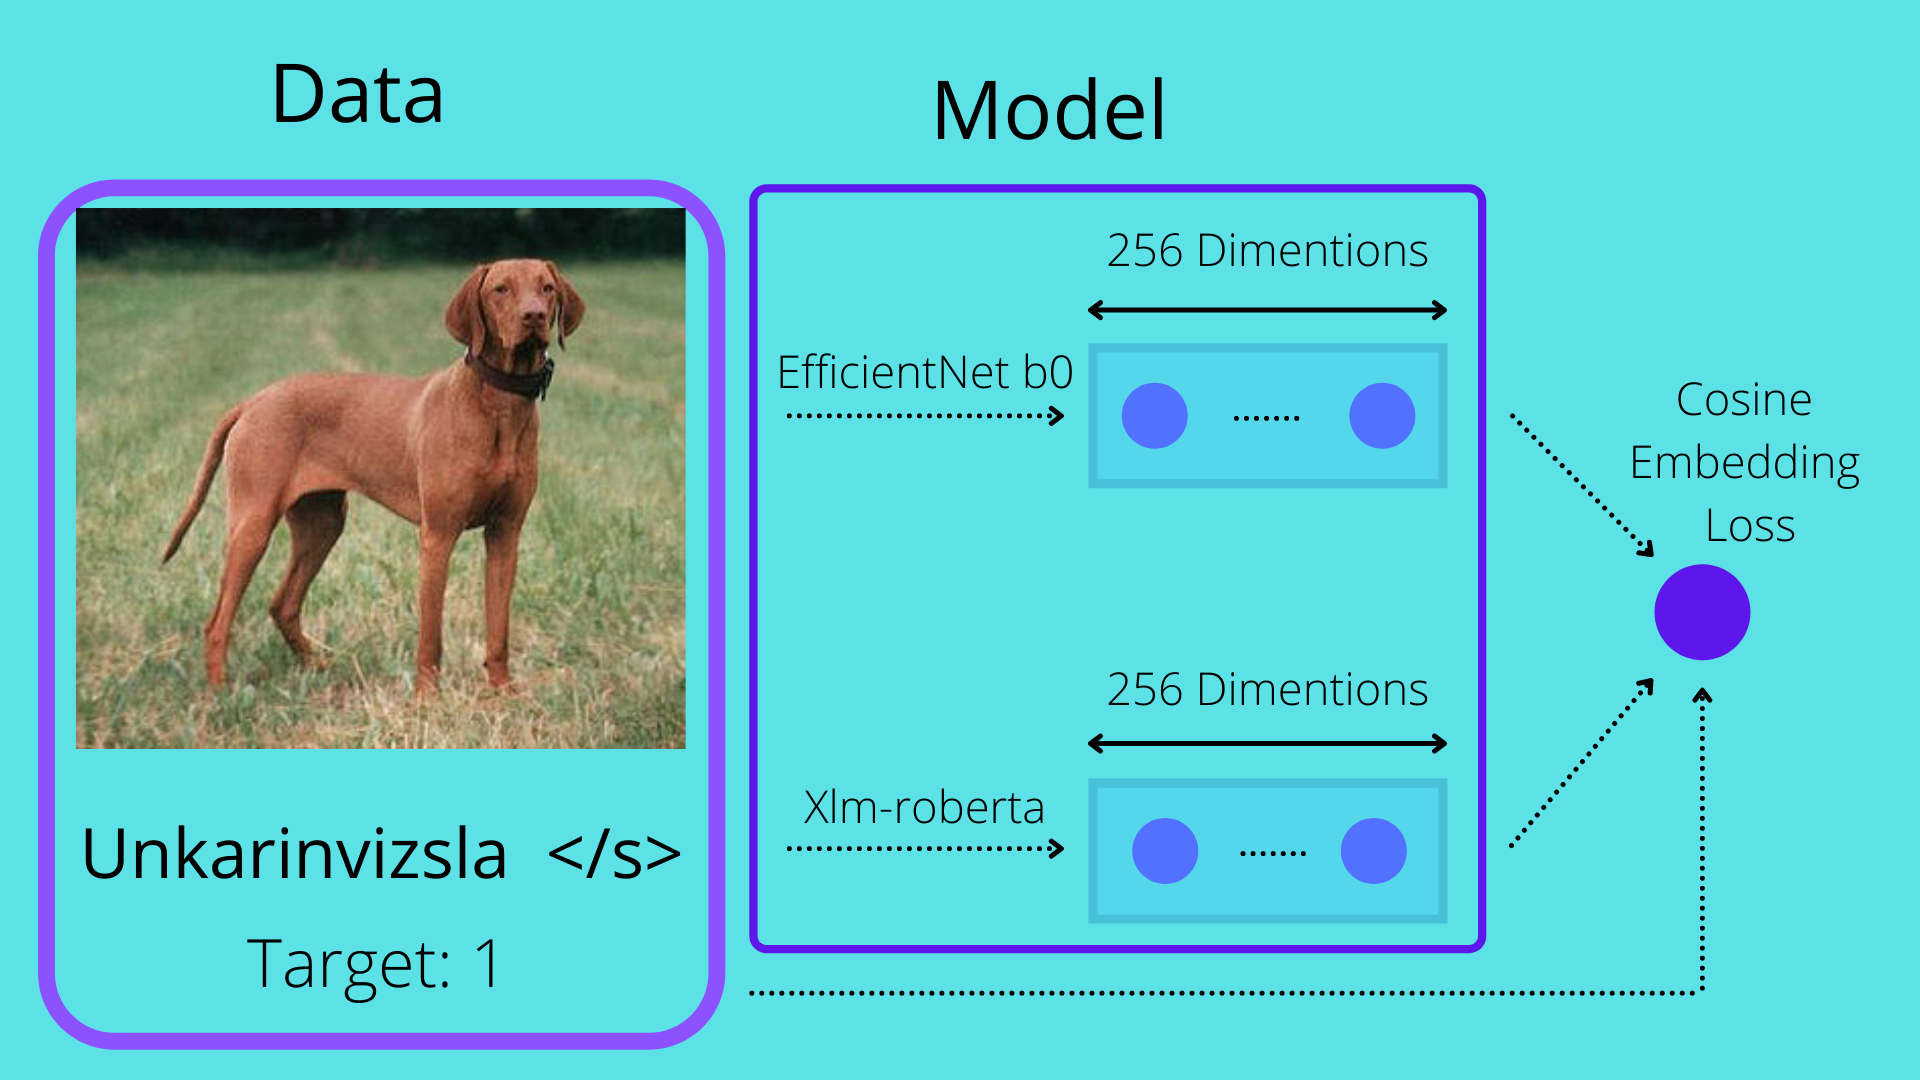

### EfficientNet + Xlm-roberta

In [ ]:
class WikipediaModel(nn.Module):
    def __init__(self, image_model, text_model, embedding_size):
        super(WikipediaModel, self).__init__()
        self.image_model = timm.create_model(image_model, pretrained=True)
        self.n_features = self.image_model.classifier.in_features
        self.image_model.reset_classifier(0)
        self.image_drop = nn.Dropout(p=0.2)
        self.image_fc = nn.Linear(self.n_features, embedding_size)

        self.text_model = AutoModel.from_pretrained(text_model)
        self.text_drop = nn.Dropout(p=0.2)
        self.text_fc = nn.Linear(768, embedding_size)

        self.freeze_backbone()

    def forward(self, images, ids, mask):
        image_features = self.image_model(images)
        image_embeddings = self.image_fc(self.image_drop(image_features))

        out = self.text_model(input_ids=ids,attention_mask=mask,
                              output_hidden_states=False)
        out = self.text_drop(out[1])
        text_embeddings = self.text_fc(out)

        return image_embeddings, text_embeddings

    def freeze_backbone(self):
        for params in self.image_model.parameters():
            params.requires_grad = False
        # Only finetune final layer
        self.image_fc.weight.requires_grad = True
        self.image_fc.bias.requires_grad = True

        for params in self.text_model.parameters():
            params.requires_grad = False
        # Only finetune final layer
        self.text_fc.weight.requires_grad = True
        self.text_fc.bias.requires_grad = True

### Efficient + Xlm-roberta + Attention

In [ ]:
class Attention(nn.Module):
    def __init__(self, feat_dim, attention=None, ffn=None, last_norm=True):
        super(Attention, self).__init__()

        self.att = attention if attention else nn.MultiheadAttention(embed_dim=feat_dim, num_heads=8)
        self.norm = nn.LayerNorm(feat_dim)
        self.ffn = ffn if ffn else nn.Sequential(nn.Linear(feat_dim, 1024), nn.ReLU(inplace=True), nn.Linear(1024, feat_dim))
        self.last_norm = nn.LayerNorm(feat_dim) if last_norm else (lambda x: x)

    def forward(self, q, k, v, attention_mask=None):
        feat = self.att(q, k, v, attention_mask)[0]
        feat = self.norm(feat + q)
        feat = self.last_norm(feat + self.ffn(feat))
        return feat

In [ ]:
class WikipediaModel_Attention(nn.Module):
    def __init__(self, image_model, text_model, embedding_size):
        super(WikipediaModel_Attention, self).__init__()

        # image feature extractor
        self.image_model = timm.create_model(image_model, pretrained=True)
        self.n_features = self.image_model.classifier.in_features
        self.image_model.reset_classifier(0)

        # text(caption/filename) feature extractor
        self.text_model = AutoModel.from_pretrained(text_model)

        # Attention
        self.att1 = Attention(
            embedding_size,
            nn.MultiheadAttention(
                embed_dim=embedding_size,
                num_heads=8,
                kdim=self.n_features,
                vdim=self.n_features))
        #self.att2 = Attention(embedding_size, last_norm=False)
        # self.att3 = Attention(embedding_size, last_norm=False)

        # fnn for caption
        self.norm = nn.LayerNorm(768)
        self.ffn = nn.Sequential(nn.Linear(768, 1024), nn.ReLU(inplace=True), nn.Linear(1024, 768))

        self.freeze_backbone()

    def forward(self, images, ids, mask, f_ids, f_mask):
        # image embedding
        image_embedding = self.image_model(images)

        # caption embedding
        out = self.text_model(input_ids=ids,attention_mask=mask,
                              output_hidden_states=False)
        caption_embedding = out['pooler_output']
        caption_embedding = caption_embedding + self.ffn(caption_embedding)

        # filename embedding
        output = self.text_model(input_ids=f_ids, attention_mask=f_mask, output_hidden_states=False)
        seq_embedding = output['last_hidden_state'] # (batch_size, sequence_length, hidden_size)
        name_embedding = output['pooler_output'] # (batch_size, hidden_size)
        #attention_mask = (1 - f_mask).bool()

        # attn
        image_embedding = image_embedding.view(batch_size, 1026, -1).permute(2, 0, 1).contiguous()
        seq_embedding = seq_embedding.permute(1, 0, 2).contiguous()
        embedding = self.att1(name_embedding, image_embedding, image_embedding)
        #embedding = self.att2(embedding, embedding, embedding, attention_mask)
        # embedding = self.att3(name_embedding, embedding, embedding, attention_mask)

        return embedding, caption_embedding

    def freeze_backbone(self):
        for params in self.image_model.parameters():
            params.requires_grad = False

        for params in self.text_model.parameters():
            params.requires_grad = False

## **Create Model Based on Architecture**

new model

In [ ]:
model = WikipediaModel_Attention(CONFIG['image_model_name'], CONFIG['text_model_name'], CONFIG['embedding_size'])
model.to(CONFIG['device']);

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


start from last time

In [ ]:
#model = WikipediaModel_Attention(CONFIG['image_model_name'], CONFIG['text_model_name'], CONFIG['embedding_size'])
#model.load_state_dict(torch.load("/content/drive/MyDrive/BDT SEM 1/ImageCaptionMatching/training/inceptionv3_xlm-roberta-base_Loss0.4338_epoch21.bin"))
#model.to(CONFIG['device']);

## **Loss Function**

In [ ]:
def criterion1(outputs1, outputs2, targets=1):
    return nn.CosineEmbeddingLoss()(outputs1, outputs2, targets)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ArcInfoNCE(nn.Module):
    def __init__(self, margin=0.5, scale=64):
        super(ArcInfoNCE, self).__init__()
        self.margin = margin
        self.scale = scale
        self.loss = nn.CrossEntropyLoss(reduction="mean")

    def create_mask(self, target, num_classes):
        batch_size = target.size(0)
        mask = torch.zeros(batch_size, num_classes, device=target.device)
        mask.scatter_(1, target.view(batch_size, 1), 1)
        return mask.bool()

    def forward(self, feat1, feat2, y=None):
        logits = F.cosine_similarity(feat1.unsqueeze(1), feat2.unsqueeze(0), dim=2)
        if y is None and feat1.size(0) == feat2.size(0):
            y = torch.arange(0, feat1.size(0), device=feat1.device, dtype=torch.long)
        mask = self.create_mask(y, num_classes=feat2.size(0))
        logits[mask] -= self.margin
        return self.loss(logits * self.scale, y)

In [ ]:
def criterion(outputs1, outputs2):
    return ArcInfoNCE()(outputs1, outputs2)

## **Training Function**

In [ ]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()

    dataset_size = 0
    running_loss = 0.0

    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        images = data['image'].to(device, dtype=torch.float)
        name_ids = data['name_ids'].to(device, dtype=torch.long)
        name_mask = data['name_mask'].to(device, dtype=torch.long)

        batch_size = ids.size(0)

        image_outputs, caption_outputs = model(images, ids, mask, name_ids, name_mask)
        loss = criterion(image_outputs, caption_outputs)
        loss = loss / CONFIG['n_accumulate']
        loss.backward()

        if (step + 1) % CONFIG['n_accumulate'] == 0:
            optimizer.step()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()

        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size

        epoch_loss = running_loss / dataset_size

        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss,
                        LR=optimizer.param_groups[0]['lr'])
    gc.collect()

    return epoch_loss

## **Validation Function**

In [ ]:
@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()

    dataset_size = 0
    running_loss = 0.0

    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        images = data['image'].to(device, dtype=torch.float)
        name_ids = data['name_ids'].to(device, dtype=torch.long)
        name_mask = data['name_mask'].to(device, dtype=torch.long)

        batch_size = ids.size(0)

        image_outputs, text_outputs = model(images, ids, mask, name_ids, name_mask)
        loss = criterion(image_outputs, text_outputs)

        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size

        epoch_loss = running_loss / dataset_size

        bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss,
                        LR=optimizer.param_groups[0]['lr'])

    gc.collect()

    return epoch_loss

## **Run Training**

In [ ]:
def run_training(model, optimizer, scheduler, device, num_epochs):
    # To automatically log gradients
    wandb.watch(model, log_freq=100)

    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))

    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_loss = np.inf
    history = defaultdict(list)

    for epoch in range(1, num_epochs + 1):
        gc.collect()
        train_epoch_loss = train_one_epoch(model, optimizer, scheduler,
                                           dataloader=train_loader,
                                           device=CONFIG['device'], epoch=epoch)

        val_epoch_loss = valid_one_epoch(model, valid_loader, device=CONFIG['device'],
                                         epoch=epoch)

        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(val_epoch_loss)

        # Log the metrics
        wandb.log({"Train Loss": train_epoch_loss})
        wandb.log({"Valid Loss": val_epoch_loss})

        # deep copy the model
        if val_epoch_loss <= best_epoch_loss:
            print(f"{b_}Validation Loss Improved ({best_epoch_loss} ---> {val_epoch_loss})")
            best_epoch_loss = val_epoch_loss
            run.summary["Best Loss"] = best_epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = "Loss{:.4f}_epoch{:.0f}.bin".format(best_epoch_loss, epoch)
            torch.save(model.state_dict(), CONFIG["root"]+CONFIG['image_model_name']+"_"+CONFIG['text_model_name']+"_attn_"+PATH)
            # Save a model file from the current directory
            print(f"Model Saved{sr_}")

        print()

    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Loss: {:.4f}".format(best_epoch_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, history

In [ ]:
def fetch_scheduler(optimizer):
    if CONFIG['scheduler'] == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CONFIG['T_max'],
                                                   eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CONFIG['T_0'],
                                                             eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == None:
        return None

    return scheduler

Define Optimizer and Scheduler

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=CONFIG['learning_rate'],
                       weight_decay=CONFIG['weight_decay'])
scheduler = fetch_scheduler(optimizer)

Start Training

In [ ]:
run = wandb.init(project="Wikipedia",
                 entity="wzhangcz",
                 name="attn_filename_test_4",
                 config=CONFIG,
                 job_type='Train')

In [ ]:
model, history = run_training(model, optimizer, scheduler,
                              device=CONFIG['device'],
                              num_epochs=CONFIG['epochs'])

[INFO] Using GPU: Tesla T4



100%|██████████| 235/235 [01:40<00:00,  2.34it/s, Epoch=1, LR=9.39e-5, Valid_Loss=36.1]


Validation Loss Improved (inf ---> 36.141525549316405)
Model Saved



100%|██████████| 235/235 [01:37<00:00,  2.42it/s, Epoch=2, LR=0.000693, Valid_Loss=36.1]


100%|██████████| 235/235 [01:37<00:00,  2.42it/s, Epoch=3, LR=0.000604, Valid_Loss=36.1]


Validation Loss Improved (36.141525549316405 ---> 36.141523126220704)
Model Saved



100%|██████████| 235/235 [01:39<00:00,  2.36it/s, Epoch=4, LR=0.000153, Valid_Loss=36.1]


Validation Loss Improved (36.141523126220704 ---> 36.14152016398112)
Model Saved



 79%|███████▉  | 1110/1406 [04:52<01:18,  3.79it/s, Epoch=5, LR=0.000455, Train_Loss=35.4]


KeyboardInterrupt: ignored

## **Visualizations**

In [ ]:
# Code taken from https://www.kaggle.com/ayuraj/interactive-eda-using-w-b-tables

# This is just to display the W&B run page in this interactive session.
from IPython import display

# we create an IFrame and set the width and height
iF = display.IFrame(run.url, width=1080, height=720)
iF